### Ratio of sn/sc

In [ ]:
import time
import timeit
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm
from scipy.stats import mannwhitneyu
import scipy.stats as stats

# transparent background
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  
})

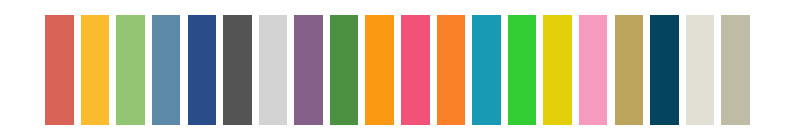

In [3]:
# define colors
purple = '#856088'
pink = '#F25278'
red = '#d96256'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#284d88'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
lightyellow = '#e4d00a'
lightgreen2 = '#32CD32'
lightblue2 = '#189AB4'
darkblue2 = '#05445E'
lightpink = '#F79AC0'
darkorange2 = '#FA8128'
darkyellow = '#BDA55D'
lightgray2 = '#E2E0D4'
lightgray3 = '#BFBBA4'

colors = [
    red, lightorange, lightgreen, lightblue, darkblue, 
    darkgray, lightgray, purple, darkgreen, darkorange,
    pink, darkorange2, lightblue2, lightgreen2, lightyellow,
    lightpink, darkyellow, darkblue2, lightgray2, lightgray3
]

plt.figure(figsize=(10, 1.5))
plt.bar(range(len(colors)), height=1, color=colors)
__ = plt.axis('off')

#### load data

In [4]:
# load processed snRNAseq data
path = 'input/df_valid.pkl'
sn_df = pd.read_pickle(path)['df_valid']
sn_df.head()

,barcode_idx,feature_idx,count,umi,barcode,feature,_type,type
3115,685,120,2,3204046,AAACCCAAGCCTATTG,Lmbrd1,Ext_L23,EX
3116,685,198,2,1572250,AAACCCAAGCCTATTG,Unc50,Ext_L23,EX
3117,685,228,1,14055112,AAACCCAAGCCTATTG,Rnf149,Ext_L23,EX
3118,685,256,1,14384360,AAACCCAAGCCTATTG,Pantr1,Ext_L23,EX
3119,685,261,1,13463740,AAACCCAAGCCTATTG,Tgfbrap1,Ext_L23,EX


In [5]:
# load ella results
fn = '../ella/output_ella/ella_merfish_mouse_brain.pkl'
res_dict = pd.read_pickle(fn)
types_list = res_dict['types_list']
genes_dict = res_dict['genes_dict']
cells_dict = res_dict['cells_dict']
p_fdr_dict = res_dict['p_fdr_dict']
score_dict = res_dict['score_dict']
lam_dict = res_dict['lam_dict']
label_dict = res_dict['label_dict']
del res_dict

In [7]:
# load ella intput df
fn = '../ella/input/merfish_mouse_brain_data_dict.pkl'
data_dict = pd.read_pickle(fn)
data_df = data_dict['data_df']

#### gene list to validate

In [8]:
gl_2valid_dict = {}
for t in types_list:
    # all genes in ella
    gl_t = np.array(genes_dict[t])
    pv_t = p_fdr_dict[t]
    # genes with sn
    df_t = sn_df[sn_df.type==t]
    sn_gl_t = df_t.feature.unique()
    # com genes
    com_t = list(set(gl_t).intersection(set(sn_gl_t)))
    print(f'{t} #{len(com_t)}')
    gl_2valid_dict[t] = list(com_t)

EX #833
IN #777
Astr #512
Oligo #674


#### find sn counts

In [9]:
# avg gene count per cell in sn data
sn_avg_dict = {}
for t in types_list:
    com_t = gl_2valid_dict[t]
    df_t = sn_df[sn_df.type==t]
    df_t_gbF = df_t.groupby('feature')
    
    sn_avg_t = []
    for g in com_t[:]:
        df_t_g = df_t_gbF.get_group(g)
        sn_avg_t.append(df_t_g.umi.mean())
        
    sn_avg_dict[t] = np.array(sn_avg_t)

#### find sc counts

In [10]:
# avg gene count per cell in our data
sc_avg_dict = {}
for t in types_list[:]:
    com_t = gl_2valid_dict[t]
    df_t = data_df[data_df.type==t]
    df_t_gbG = df_t.groupby('gene')
    
    sc_avg_t = []
    for g in com_t[:]:
        df_t_g = df_t_gbG.get_group(g)
        sc_avg_g = np.mean(df_t_g[['umi','cell']].groupby('cell').sum().values)
        sc_avg_t.append(sc_avg_g)
        
    sc_avg_dict[t] = np.array(sc_avg_t)
    print(f'{t} minavg={np.min(sc_avg_t):.2f} maxavg={np.max(sc_avg_t):.2f}')

EX minavg=1.00 maxavg=30.78
IN minavg=1.00 maxavg=29.63
Astr minavg=1.00 maxavg=12.33
Oligo minavg=1.00 maxavg=27.26


#### compute sn/sc ratio for `gl_2valid_dict`

In [37]:
ratio_dict = {}
for t in types_list[:]:
    com_t = gl_2valid_dict[t]
    sn_t = sn_avg_dict[t]
    sc_t = sc_avg_dict[t]
    ratio_t = sn_t/sc_t
    ratio_dict[t] = ratio_t
    print(f'{t} min={np.min(ratio_t):.2f} max={np.max(ratio_t):.2f}')

EX min=155907.89 max=16725463.00
IN min=37375.37 max=16634682.00
Astr min=455133.78 max=12369385.28
Oligo min=179477.59 max=14993485.00


In [48]:
# find genes and their ratio, label, score 
validate_genes_dict = gl_2valid_dict

ratio_df_dict = {}
for t in types_list:
    pv_t = p_fdr_dict[t]
    label_t = label_dict[t]
    score_t = score_dict[t]
    
    genes_t = np.array(genes_dict[t])
    genes2_t = list(set(genes_t).intersection(validate_genes_dict[t]))

    ratio2_t = np.zeros(len(genes2_t))
    score2_t = np.zeros(len(genes2_t))
    label2_t = np.zeros(len(genes2_t))
    sn2_t = np.zeros(len(genes2_t))
    sc2_t = np.zeros(len(genes2_t))
    
    for ig, g in enumerate(genes2_t):
        ig_ratio = np.where(np.array(validate_genes_dict[t]) == g)[0][0]
        ratio_g = ratio_dict[t][ig_ratio]
        sn_g = sn_avg_dict[t][ig_ratio]
        sc_g = sc_avg_dict[t][ig_ratio]
        ratio2_t[ig] = ratio_g
        ig_score = np.where(np.array(genes_dict[t]) == g)[0][0]
        score_g = score_t[ig_score]
        label_g = label_t[ig_score]
        score2_t[ig] = score_g
        label2_t[ig] = label_g
        sn2_t[ig] = sn_g
        sc2_t[ig] = sc_g
    ratio_df_dict[t] = pd.DataFrame({'gene':genes2_t, 'ratio':ratio2_t, 'score':score2_t, 'label':label2_t, 'sn':sn2_t, 'sc':sc2_t})

#### all types together

In [72]:
# merge together
_merged_df = pd.concat(ratio_df_dict.values(), ignore_index=True)
_merged_df.head(3)

,gene,ratio,score,label,sn,sc
0,Fam20a,8.351584e+06,0.494960,-1.0,9.440921e+06,1.130435
1,Scn7a,6.831205e+06,0.121970,0.0,8.801745e+06,1.288462
2,Aff2,5.180305e+06,0.605848,-1.0,9.145918e+06,1.765517


In [177]:
merged_df = _merged_df.copy()
merged_df[(merged_df.label==-1)&(merged_df.sc<1.5)] = np.nan #!!!<<<
merged_df = merged_df.dropna()
merged_df.groupby('label').mean()

/tmp/ipykernel_2469097/143066240.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_df.groupby('label').mean()


,ratio,score,sn,sc
label,,,,
-1.0,4.296697e+06,0.535854,8.835656e+06,2.501341
0.0,5.588951e+06,0.164947,8.935353e+06,1.880348
1.0,5.734003e+06,0.446656,8.893841e+06,1.823403
2.0,4.667575e+06,0.615929,8.892293e+06,2.441006
3.0,4.301995e+06,0.748085,9.064095e+06,2.912524


In [179]:
# wilcoxon cluster 1-2 vs 3-4 
sample1 = merged_df['ratio'][(merged_df.label==0)|(merged_df.label==1)].values
sample2 = merged_df['ratio'][(merged_df.label==2)|(merged_df.label==3)].values
__statistic, p_value1 = mannwhitneyu(sample1, sample2)
print(f'1-2 vs 3-4 \np={p_value1}')
print(f'fc={np.mean(sample1)/np.mean(sample2)}')
p12 = [p_value1]

# wilcoxon cluster 1 vs all else
sample3_df = merged_df[['ratio', 'sc']][(merged_df.label==-1)|(merged_df.label==2)|(merged_df.label==3)]
sample3 = sample3_df[sample3_df.sc>-999].ratio.values
__statistic, p_value2 = mannwhitneyu(sample1, sample3)
print(f'1-2 vs others \np={p_value2}')
print(f'fc={np.mean(sample1)/np.mean(sample3)}')
p13 = [p_value2]

1-2 vs 3-4 
p=1.4416518364554874e-15
fc=1.2500117334245855
1-2 vs others 
p=2.0608133271785764e-31
fc=1.2887173622115213


In [180]:
# bar plot
means = [
    (merged_df.ratio)[(merged_df.label==0)|(merged_df.label==1)].mean(),
    (merged_df.ratio)[(merged_df.label==2)|(merged_df.label==3)].mean(),
    (merged_df.ratio)[(merged_df.label==-1)|(merged_df.label==2)|(merged_df.label==3)].mean(),
]

# Individual data points for each category
data_points = [
    (merged_df.ratio)[(merged_df.label==0)|(merged_df.label==1)],
    (merged_df.ratio)[(merged_df.label==2)|(merged_df.label==3)],
    (merged_df.ratio)[(merged_df.label==-1)|(merged_df.label==2)|(merged_df.label==3)],
]

# remove outliers
lbs = []
ubs = []
data_points2 = []
for j in range(len(data_points)):
    data_j = data_points[j]
    
    # IQR
    Q1 = np.percentile(data_j, 25)
    Q3 = np.percentile(data_j, 75)
    # IQR = Q3 - Q1
    lower_bound = Q1
    upper_bound = Q3
    lbs.append(np.maximum(means[j]-lower_bound,0))
    ubs.append(np.maximum(upper_bound-means[j],0))
    
    data_j2 = data_j[(data_j >= lower_bound) & (data_j <= upper_bound)]
    
    data_points2.append(data_j2)

In [181]:
def sig_symb(p_value):
    if p_value <= 0.001:
        sig_symbol = '***'
    elif p_value <= 0.01:
        sig_symbol = '**'
    elif p_value <= 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    return sig_symbol

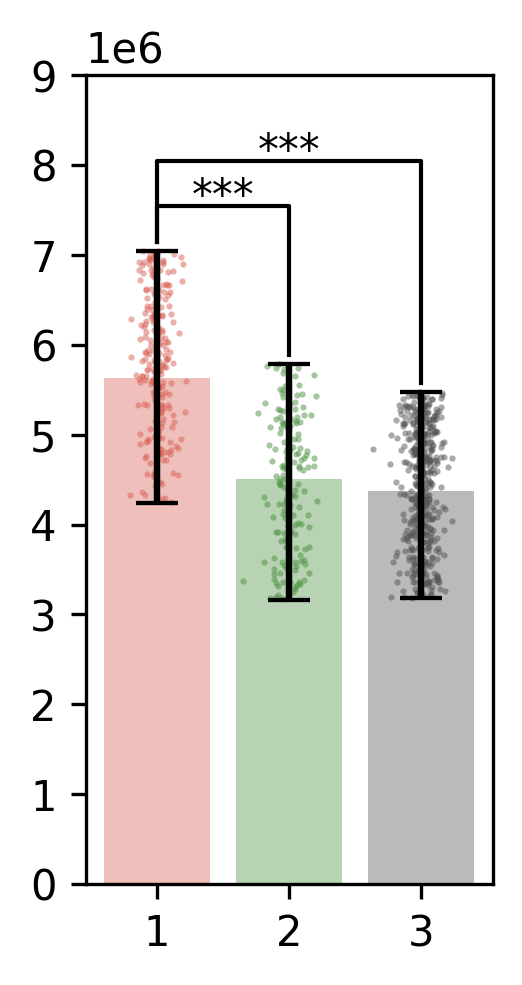

In [182]:
nr = 1
nc = 1
ss_nr = 3.5
ss_nc = 7/4
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

colors = [red, darkgreen, darkgray]
bar_pos = np.array([1,2,3])

# bar
bars = ax.bar(bar_pos, means, yerr=np.array([lbs, ubs]), 
              capsize=5, 
              color=colors,
              zorder=1,
              alpha=0.4)
# the std 
bars = ax.bar(bar_pos, means, yerr=np.array([lbs, ubs]), 
              capsize=5, 
              zorder=3,
              alpha=0)

# Define the width of the spread
width = bars[0].get_width() / 1.0

# Adding spread dots
for _i, (i, data) in enumerate(zip(bar_pos, data_points2)):
    # Spread dots around the center of the bar
    x = np.random.normal(i, width/10, size=len(data))
    ax.plot(x, data, '.', 
            color=colors[_i], 
            markersize=3,
            markeredgewidth=0, mec='none', alpha=0.5, zorder=1)

# add 1 vs 2-5 pv
hgap_big = 5e5
hgap_small = 1e5
for j, p in enumerate(p12[:]):
    x1 = bar_pos[::3][j]
    x2 = x1+1
    bar1_max = means[j*3]+ubs[j*3]
    bar2_max = means[j*3+1]+ubs[j*3+1]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_small, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_small],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')
    
# add 1 vs others pv
hgap_big = 5e5*2
hgap_small = 1e5
for j, p in enumerate(p13[:]):
    x1 = bar_pos[::3][j]
    x2 = x1+2
    bar1_max = means[j*3]+ubs[j*3]
    bar2_max = means[j*3+2]+ubs[j*3+2]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_small, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_small],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')
    
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_ylim((0, 9e6))

# plt.savefig(f'figs/fig_snRNAseq_all.pdf', dpi=300, bbox_inches='tight')